In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import os
import json
from collections import OrderedDict
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py

In [3]:
from agnfinder.tf_sampling import deep_emulator, api, run_sampler
# from agnfinder.tf_sampling.api import SamplingProblem
# from agnfinder.tf_sampling.hmc import SamplerHMC

In [4]:
from agnfinder.tf_sampling import hmc

In [5]:
# tf.enable_eager_execution()

In [8]:
os.chdir('/home/walml/repos/agnfinder')

In [116]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling', 'inclination']

In [117]:
checkpoint_dir = 'results/checkpoints/latest'
new_emulator = False

In [118]:
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=new_emulator)

In [119]:
# _, _, x_test, y_test = deep_emulator.data()
# x_test = x_test.astype(np.float32)
# y_test = y_test.astype(np.float32)


In [120]:
# x_target = np.ones(7) * .5
# distance = np.sum(np.abs(x_test - x_target), axis=1)
# n_best = np.argmin(distance)
# n_best


# 1977

In [121]:
# x_test[1977]

In [122]:
param_dim = 8
n_chains = 96

In [123]:
# galaxy_n = n_best
# true_params = x_test[galaxy_n]
# true_observation = deep_emulator.denormalise_photometry(y_test[galaxy_n])

In [280]:
# galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)
# galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)
galaxy_n = 2
galaxy_loc = 'results/emulated_sampling/latest/galaxy_{}_performance_0.h5'.format(galaxy_n)
assert os.path.isfile(galaxy_loc)
f = h5py.File(galaxy_loc, mode='r')
samples = f['samples'][...]
true_params = f['true_params'][...]
# redshift = f['redshift'][...]
fixed_params = f['fixed_params'][...]
# redshift = np.array(0.1).astype(np.float32)
true_observation = f['true_observations'][...]
uncertainty = np.expand_dims(f['uncertainty'][...], 0)

fixed_params = np.stack([fixed_params for _ in range(n_chains)], axis=0).reshape(-1, 1)
true_observation = np.stack([true_observation for _ in range(n_chains)], axis=0)
true_params = np.stack([true_params for _ in range(n_chains)], axis=0)



In [281]:
fixed_params.shape

(96, 1)

In [238]:
uncertainty.shape

(1, 8)

In [239]:
true_observation.shape, redshift.shape

((96, 8), ())

In [340]:
# import tensorflow_probability as tfp

In [344]:
# hmc.find_minima()

<module 'agnfinder.tf_sampling.hmc' from '/home/walml/repos/agnfinder/agnfinder/tf_sampling/hmc.py'>

In [348]:
# def func(x):
#     return tf.pow(x, 2)

# initial_guess = tf.reshape(tf.constant(6.), (-1, 1))

In [406]:
# optimised_start = hmc.optimised_start(emulator_fixed_scale, true_observation, param_dim, n_chains, steps=3000)
# optimised_start = fix_scale(optimised_start)
optimised_start = hmc.optimised_start(emulator, true_observation, fixed_params, uncertainty, param_dim, n_chains, steps=3000)
# optimised_start = optimised_start.numpy()



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:07<00:30,  7.72s/it]

 40%|████      | 2/5 [00:14<00:22,  7.52s/it]

 60%|██████    | 3/5 [00:21<00:14,  7.37s/it]

 80%|████████  | 4/5 [00:29<00:07,  7.38s/it]

100%|██████████| 5/5 [00:36<00:00,  7.23s/it]

(96, 8)


In [407]:
optimised_df = pd.DataFrame(data=[dict(zip(params, state)) for state in optimised_start])
optimised_df['method'] = 'optimised'

In [408]:
true_params[0]

array([0.8925699 , 0.02032123, 0.42358112, 0.05422792, 0.21411249,
       0.6311261 , 0.2257177 , 0.732566  ], dtype=float32)

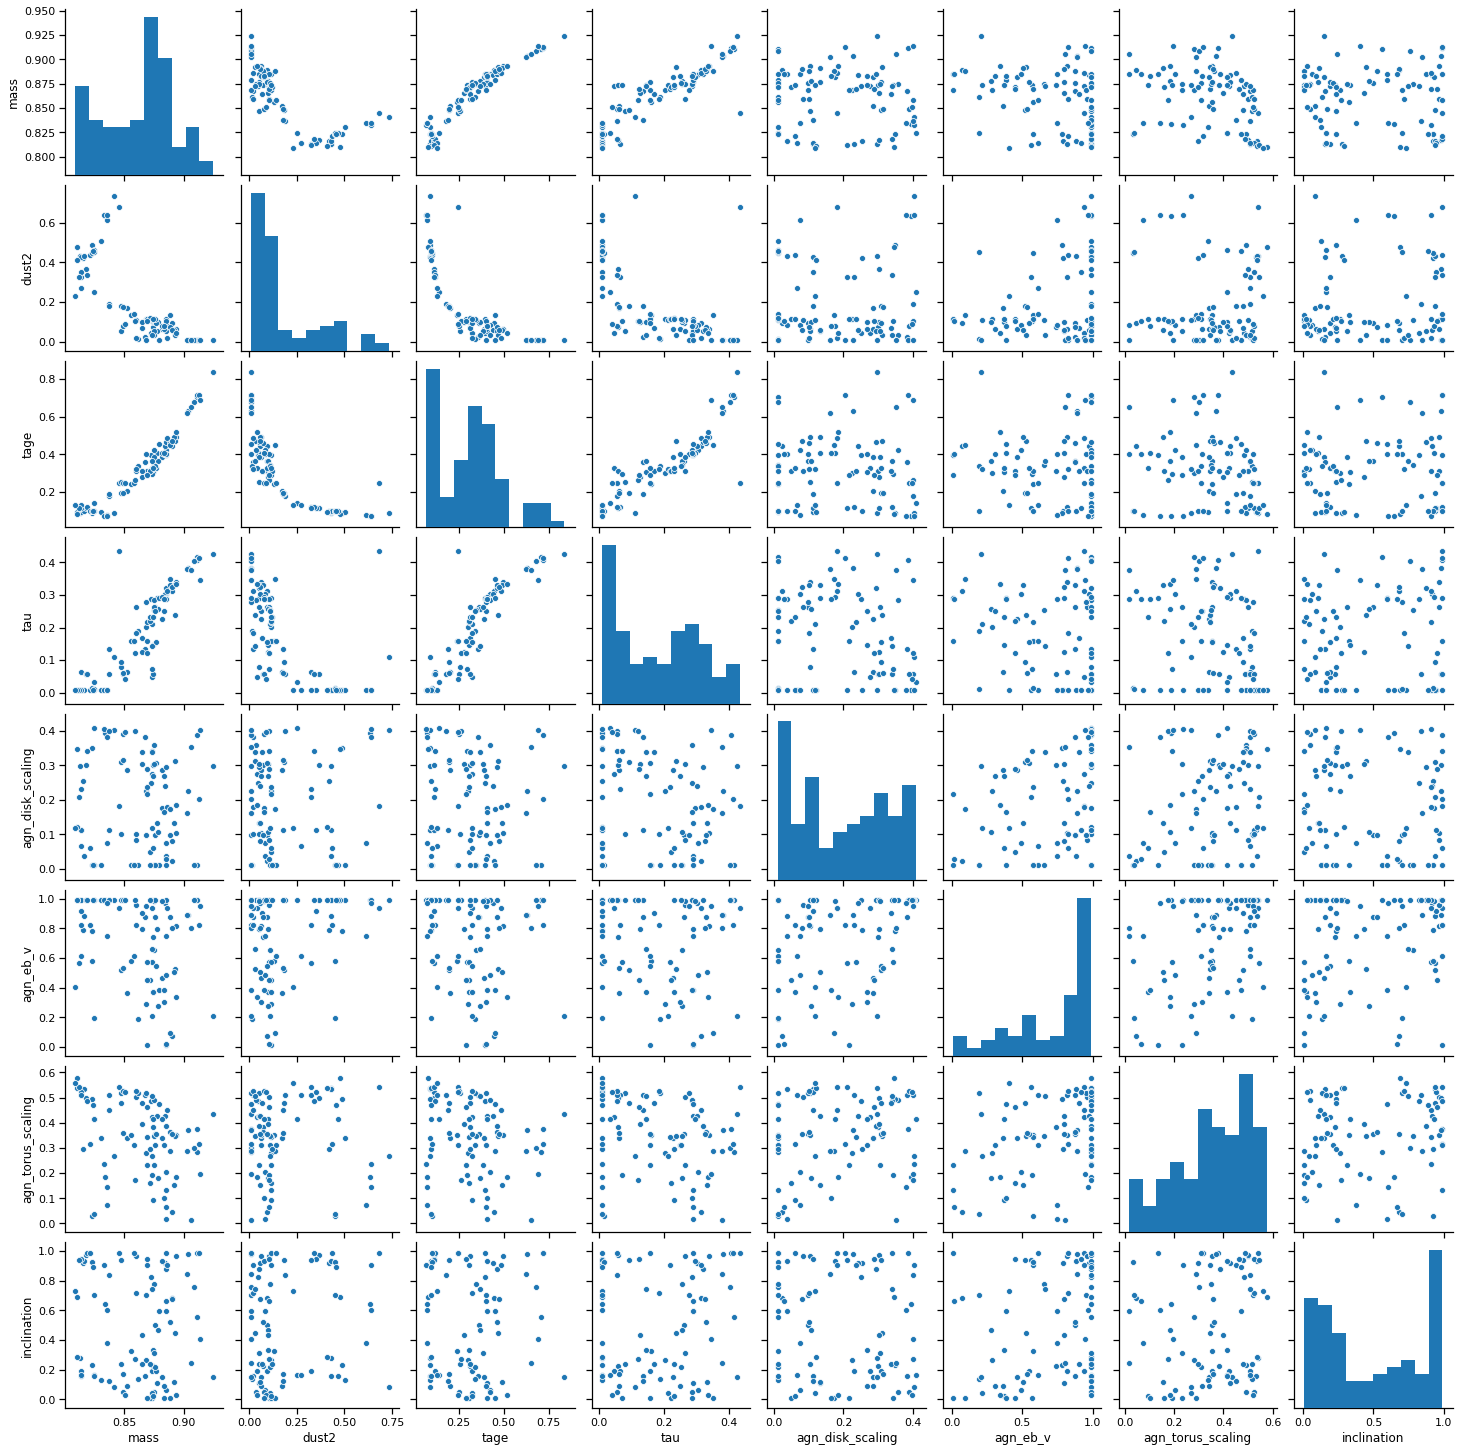

In [409]:
sns.pairplot(optimised_df)

In [299]:
# random_start = hmc.many_random_starts(emulator, true_observation, param_dim, n_chains, 1000).numpy()

In [300]:
# random_df = pd.DataFrame(data=[dict(zip(params, state)) for state in random_start])
# random_df['method'] = 'best_random'

In [301]:
# sns.pairplot(random_df)

In [302]:
# correct_df = pd.DataFrame(data=[dict(zip(params, true_params))])
# correct_df['method'] = 'correct'
# correct_df.head()

In [410]:

rough_start = hmc.roughly_correct_start(true_params, n_chains).numpy()
rough_df = pd.DataFrame(data=[dict(zip(params, state)) for state in rough_start])
rough_df['method'] = 'roughly_correct'
rough_df.head()

,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,inclination,method
0,0.899283,0.026686,0.435550,0.063940,0.240182,0.656875,0.252533,0.758971,roughly_correct
1,0.906904,0.043110,0.447804,0.076853,0.229913,0.642493,0.248628,0.754249,roughly_correct
2,0.916513,0.039946,0.452626,0.068705,0.221773,0.646880,0.238444,0.752894,roughly_correct
3,0.909644,0.037629,0.442483,0.064976,0.234554,0.641507,0.239372,0.747272,roughly_correct
4,0.899621,0.029406,0.435090,0.057863,0.222482,0.653292,0.231716,0.758140,roughly_correct


In [411]:
# df = pd.concat([correct_df, rough_df, random_df, optimised_df]).reset_index(drop=True)
df = pd.concat([rough_df, optimised_df]).reset_index(drop=True)

In [412]:
true_params[0]

array([0.8925699 , 0.02032123, 0.42358112, 0.05422792, 0.21411249,
       0.6311261 , 0.2257177 , 0.732566  ], dtype=float32)

In [413]:
df

,mass,dust2,tage,tau,agn_disk_scaling,agn_eb_v,agn_torus_scaling,inclination,method
0,0.899283,0.026686,0.435550,0.063940,0.240182,0.656875,0.252533,0.758971,roughly_correct
1,0.906904,0.043110,0.447804,0.076853,0.229913,0.642493,0.248628,0.754249,roughly_correct
2,0.916513,0.039946,0.452626,0.068705,0.221773,0.646880,0.238444,0.752894,roughly_correct
3,0.909644,0.037629,0.442483,0.064976,0.234554,0.641507,0.239372,0.747272,roughly_correct
4,0.899621,0.029406,0.435090,0.057863,0.222482,0.653292,0.231716,0.758140,roughly_correct
...,...,...,...,...,...,...,...,...,...
187,0.884570,0.106761,0.400206,0.288192,0.028881,0.017613,0.063900,0.665955,optimised
188,0.892933,0.041819,0.517685,0.334828,0.185411,0.339113,0.184164,0.028966,optimised
189,0.913767,0.010000,0.689647,0.346286,0.401743,0.949822,0.195402,0.405123,optimised
190,0.872879,0.033408,0.366833,0.144146,0.339612,0.662025,0.508106,0.745973,optimised


For this galaxy where tage is very small, tau truly doesn't matter

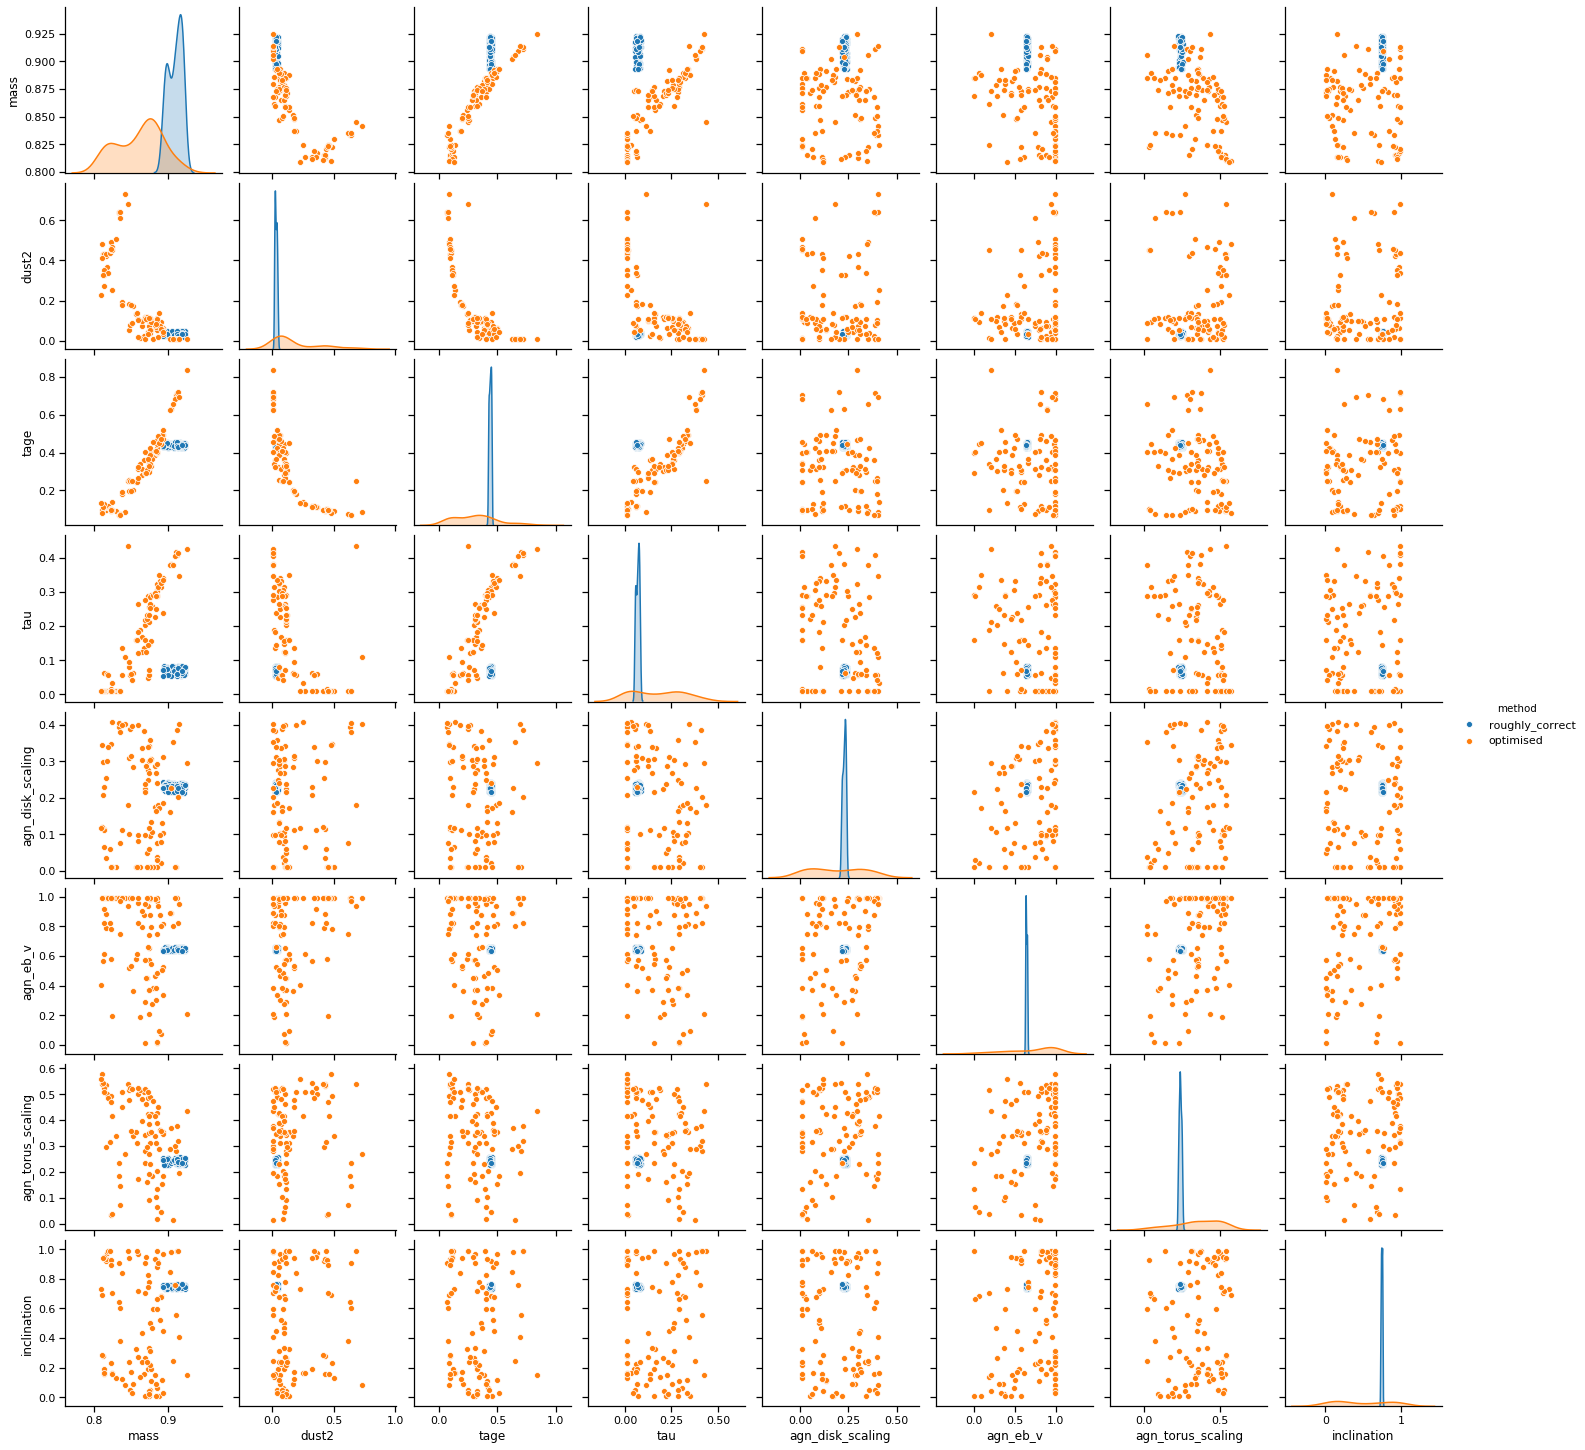

In [414]:
sns.pairplot(df, hue='method')

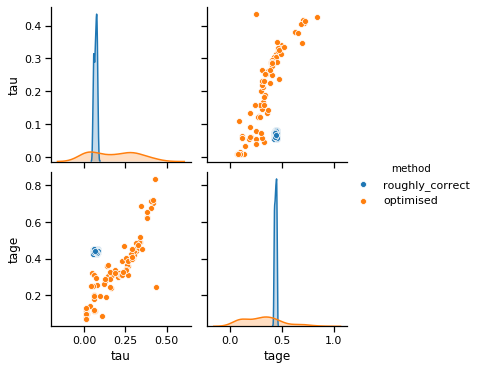

In [415]:
sns.pairplot(df[['tau', 'tage', 'method']], hue='method')

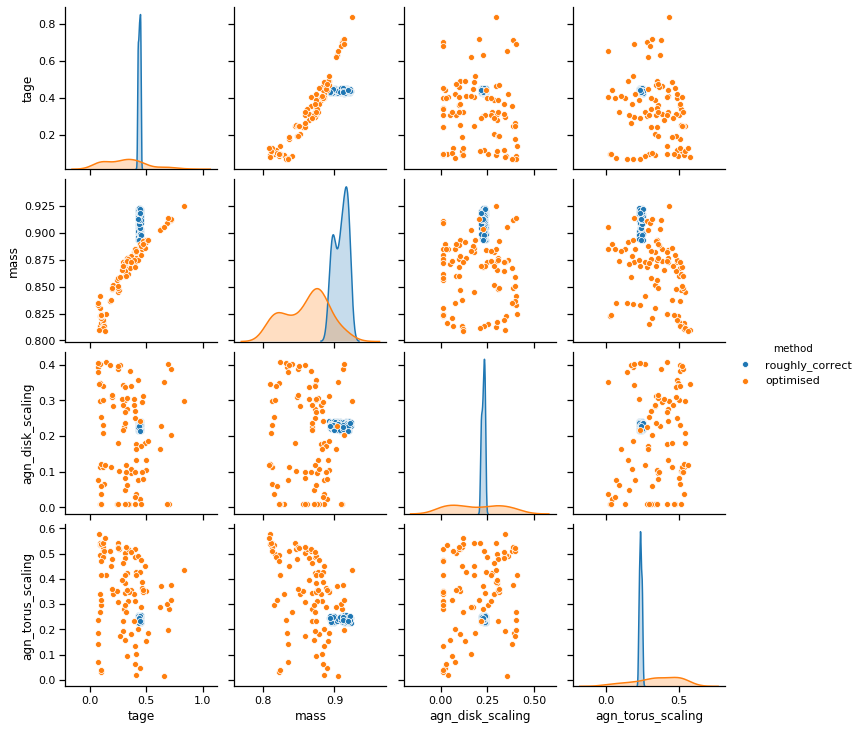

In [416]:
sns.pairplot(df[['tage', 'mass', 'agn_disk_scaling', 'agn_torus_scaling', 'method']], hue='method')

if we fix the scaling params, does it therefore fix tage/tau/dust?

In [254]:
# def fix_scale(p):
#     p_slices = tf.split(p, 9, axis=1)
#     for scale_index in [0, 4, 6]:
#         p_slices[scale_index] = tf.fill([n_chains, 1], true_params[scale_index])
#     return tf.squeeze(tf.stack(p_slices, axis=1))

In [255]:
# def emulator_fixed_scale(p, training):
#     p_fixed = fix_scale(p)
#     return emulator(p_fixed)

In [256]:
# optimised_start_fixed = hmc.optimised_start(emulator_fixed_scale, true_observation, fixed_params, uncertainty, param_dim, n_chains, steps=3000)
# optimised_start_fixed = optimised_start_fixed.numpy()

In [257]:
# plt.scatter(optimised_start_fixed[:, 3], optimised_start_fixed[:, 4])

In [258]:
# sns.pairplot(df[['mass', 'agn_disk_scaling', 'agn_torus_scaling', 'method']], hue='method')

In [259]:
# dfs = df[df['method']=='optimised']
# c_col = 'tage'
# vals = (dfs[c_col] - dfs[c_col].min()) / (dfs[c_col].max() - dfs[c_col].min())
# colors = [(0, v, 0) for v in vals]
# plt.scatter(dfs['mass'], dfs['agn_disk_scaling'], c=colors)

In [260]:
# plt.scatter(dfs['agn_torus_scaling'], dfs['agn_disk_scaling'], c=colors)

In [261]:


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(10, 20)
# ax.plot_trisurf(dfs['mass'], dfs['agn_disk_scaling'], dfs['agn_torus_scaling'])
# ax.set_xlabel('mass')
# ax.set_ylabel('agn_disk_scaling')
# ax.set_zlabel('agn_torus_scaling')

In [262]:
# assert False

AssertionError: 

In [ ]:
# def emulator_with_redshift(x, redshift=.001):  # TODO correct this
#     redshifts = np.array([redshift for n in range(len(x))]).reshape(-1, 1)
#     x_with_redshift = tf.concat([redshifts, x], axis=1)
#     return emulator(x_with_redshift)

In [ ]:
# phot_from_opt = emulator_with_redshift(df[df['method'] == 'optimised'][params].values).numpy()
# _ = plt.plot(phot_from_opt.transpose(), alpha=.3, linestyle='', marker='+', color='r')

# phot_from_actual = emulator_with_redshift(df[df['method'] == 'roughly_correct'][params].values).numpy()
# _ = plt.plot(phot_from_actual.transpose(), linestyle='', marker='+', label='actual')
# # phot_from_actual

# # plt.plot(-np.log10(true_observation), linestyle='', marker='+', color='k', label='obs')
# # plt.legend()

In [ ]:
# params[2]

In [ ]:
# opt = df[df['method'] == 'optimised'][params].values
# plt.hist(opt[:, 2])  # but can find solutions by changing other things, presumably. Which things?

In [ ]:
# opt = df[df['method'] == 'optimised'][params].values
# opt[:, 2] = .1  # tage does matter
# phot_from_opt = emulator(opt).numpy()
# _ = plt.plot(phot_from_opt.transpose(), alpha=.3, linestyle='', marker='+', color='r')

# phot_from_actual = emulator(df[df['method'] == 'correct'][params].values).numpy()
# _ = plt.plot(phot_from_actual.transpose(), linestyle='', marker='+', label='actual')
# # phot_from_actual

# plt.plot(-np.log10(true_observation), linestyle='', marker='+', color='k', label='obs')
# plt.legend()

In [417]:
log_prob = api.get_log_prob_fn(emulator, true_observation, fixed_params, uncertainty)
# single_log_prob = api.get_log_prob_fn(emulator, true_observation, batch_dim=None)

In [418]:
rough_start.shape, fixed_params.shape

((96, 8), (96, 1))

In [419]:
fixed_params.shape, true_observation.shape, uncertainty.shape, rough_start.shape

((96, 1), (96, 8), (1, 8), (96, 8))

In [420]:
log_prob(true_params).numpy()[0]

-159.81122

In [421]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 
       10205.12640526])

In [422]:
true_observation[0]

array([2.2391704e-09, 1.5006867e-08, 5.6111151e-08, 8.8025153e-08,
       1.1658976e-07, 2.2820943e-07, 2.0453479e-07, 1.5258195e-07],
      dtype=float32)

In [423]:
fixed_params = np.stack(fixed_params, axis=0)

In [424]:
true_params.shape

(96, 8)

In [425]:
def get_expected_photometry(x):
    x_with_fixed_params = tf.concat([fixed_params, x], axis=1)
    return deep_emulator.denormalise_photometry(emulator(x_with_fixed_params, training=False)).numpy()

In [426]:
# get_expected_photometry(true_params)

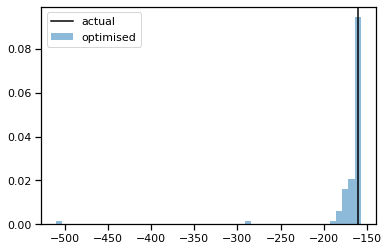

In [427]:
plt.clf()
alpha = 0.5
# plt.hist(log_prob(random_start).numpy(), alpha=alpha, density=True, label='random')
# plt.hist(log_prob(rough_start).numpy(), alpha=alpha, density=True, label='rough')
opt_log_prob = log_prob(optimised_start).numpy()
plt.hist(opt_log_prob[opt_log_prob > -1e4], alpha=alpha, density=True, label='optimised', bins=50)
plt.axvline(log_prob(true_params).numpy()[0], color='k', label='actual')
# plt.axvline(log_prob(optimised_start).numpy().min(), color='r', label='optimised')
# plt.axvline(log_prob(optimised_start).numpy().max(), color='r')
plt.legend()

In [428]:
np.sum(opt_log_prob > -180)

91

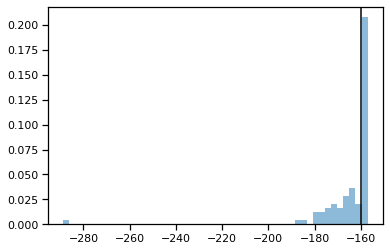

In [429]:
plt.hist(opt_log_prob[opt_log_prob > -300], alpha=alpha, density=True, label='optimised', bins=50)
plt.axvline(log_prob(true_params).numpy()[0], color='k', label='actual')

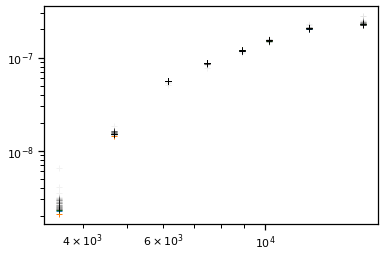

In [430]:
plt.loglog(wavelengths, true_observation[0], linestyle='', marker='+')
plt.loglog(wavelengths, get_expected_photometry(true_params)[0], linestyle='', marker='+')
plt.loglog(wavelengths, get_expected_photometry(optimised_start)[np.argmax(opt_log_prob)], linestyle='', marker='+')
for n in range(len(optimised_start)):
    plt.loglog(wavelengths, get_expected_photometry(optimised_start)[n], linestyle='', marker='+', color='k', alpha=0.05)

The true params are at high log prob, followed by rough and then random (as-is).
Optimised does an excellent job at finding high log prob solutions, actually finding values much better than the real ones!

In [ ]:
assert False

In [104]:
batch_dim = 10
param_dim = 8
true_observation_cut = tf.constant(true_observation[:batch_dim], dtype=tf.float32)
random_params = tf.random.uniform([batch_dim, param_dim], minval=0., maxval=1., dtype=tf.float32)
fixed_params = tf.random.uniform([batch_dim, 1], minval=0., maxval=1., dtype=tf.float32)
uncertainty = tf.constant(np.ones([batch_dim, param_dim]), dtype=tf.float32)
log_prob_many = api.get_log_prob_fn(emulator, true_observation_cut, fixed_params, uncertainty)
%timeit log_prob_many(random_params)

390 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
batch_dim = 100
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)

In [ ]:
batch_dim = 300
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)

In [ ]:
batch_dim = 1000
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)

In [ ]:
batch_dim = 5000
random_params = tf.random.uniform([batch_dim, 7], minval=0., maxval=1.)
log_prob_many = api.get_log_prob_fn(emulator, true_observation, batch_dim=batch_dim)
%timeit log_prob_many(random_params)

In [ ]:
log_probs = log_prob_many(random_params).numpy()
np.max(log_probs)
plt.hist(np.sort(log_probs)[-100:])

In [ ]:
np.sort(log_probs)